In [1]:
import gym
import torch
from gym import spaces
from collections import defaultdict
import heapq
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../Env/3D/')
from DMP_simulator_3d_static_circle import deep_mobile_printing_3d1r
import heapq 

In [2]:
def localization(action, obs, new_obs, previous_position):
    [y,x]=previous_position
    # 0 left, 1 right, 2 up, 3 down, 4 drop
    obs = obs[0][:49].reshape(7, 7)
    new_obs = new_obs[0][:49].reshape(7, 7)
    size_x = len(obs)
    size_y = len(obs[0])

    new_x, new_y = x, y
    dx = [-1, 1, 0, 0]
    dy = [0, 0, 1, -1]
    if action == 4:
        return new_x, new_y
    elif (obs == new_obs).all():
        print('enter action_none')
        new_x = x + dx[action]
        new_y = y + dy[action]


    else:
        if action == 0:
            if (obs[:, :size_x + dx[action]] == new_obs[:, -dx[action]:]).all():
                print('enter action0_1')
                new_x = x + dx[action]
            elif (obs[:, :size_x + 2 * dx[action]] == new_obs[:, -2 * dx[action]:]).all():
                print('enter action0_2')
                new_x = x + 2 * dx[action]
            elif (obs[:, :size_x + 3 * dx[action]] == new_obs[:, -3 * dx[action]:]).all():
                print('enter action0_3')
                new_x = x + 3 * dx[action]
        elif action == 1:  # right
            if (new_obs[:, :size_x - dx[action]] == obs[:, dx[action]:]).all():
                print('enter action1_1')
                new_x = x + dx[action]
            elif (new_obs[:, :size_x - 2 * dx[action]] == obs[:, 2 * dx[action]:]).all():
                print('enter action1_2')
                new_x = x + 2 * dx[action]
            elif (new_obs[:, :size_x - 3 * dx[action]] == obs[:, 3 * dx[action]:]).all():
                print('enter action1_3')
                new_x = x + 3 * dx[action]
        elif action == 2:  # up
            if (new_obs[:size_y - dy[action], :] == obs[dy[action]:, :]).all():
                print('enter action2_1')
                new_y = y + dy[action]
            elif (new_obs[:size_y - 2 * dy[action], :] == obs[2 * dy[action]:, :]).all():
                print('enter action2_2')
                new_y = y + 2 * dy[action]
            elif (new_obs[:size_y - 3 * dy[action], :] == obs[3 * dy[action]:, :]).all():
                print('enter action2_3')
                new_y = y + 3 * dy[action]
        elif action == 3:
            if (obs[:size_y + dy[action], :] == new_obs[-dy[action]:, :]).all():
                print('enter action3_1')
                new_y = y + dy[action]
            elif (obs[:size_y + 2 * dy[action], :] == new_obs[-2 * dy[action]:, :]).all():
                print('enter action3_2')
                new_y = y + 2 * dy[action]
            elif (obs[:size_y + 3 * dy[action], :] == new_obs[-3 * dy[action]:, :]).all():
                print('enter action3_3')
                new_y = y + 3 * dy[action]

    if new_x < 0: new_x = 0
    if new_x >= env.plan_width: new_x = env.plan_width - 1
    if new_y < 0: new_y = 0
    if new_y > env.plan_width: new_y = env.plan_width - 1

    # if the robot can see the wall, it can localize its position
    dff_y = 0
    dff_x = 0
    mid = size_x // 2

    if new_obs[0][mid] == -1.0:  # check upper_all
        print('check_up')
        for i in range(1, env.HALF_WINDOW_SIZE):
            if new_obs[i][mid] == -1.0:
                dff_y -= 1
        new_y = env.HALF_WINDOW_SIZE - 1 + dff_y
    elif new_obs[size_y - 1][mid] == -1.0:  # check down_wall
        print('check_down')
        for i in range(size_y - 2, env.HALF_WINDOW_SIZE, -1):
            if new_obs[i][mid] == -1.0:
                dff_y += 1
        new_y = env.plan_height - env.HALF_WINDOW_SIZE + dff_y
    if new_obs[mid][0] == -1.0:  # check left_wall
        print('check_left')
        for i in range(1, env.HALF_WINDOW_SIZE):
            if new_obs[mid][i] == -1.0:
                dff_x -= 1
        new_x = env.HALF_WINDOW_SIZE - 1 + dff_x
    elif new_obs[mid][size_x - 1] == -1.0:  # check right_wall
        print('check_right')
        for i in range(size_x - 2, env.HALF_WINDOW_SIZE, -1):
            if new_obs[mid][i] == -1.0:
                dff_x += 1
        new_x = env.plan_width - env.HALF_WINDOW_SIZE + dff_x
    return [new_x, new_y]

In [3]:
def planing(position,obs,current_action_prior):
    ###   reshape the input value 
    obs = obs[0][:49].reshape(7, 7)
    current_position_row = position[0] + env.HALF_WINDOW_SIZE
    current_position_column = position[1] + env.HALF_WINDOW_SIZE
    
    ### check avaliable action by surroding bricks 
    
    avaliable_action= [0,1,2,3] 
    if obs[3,2]>0:
        avaliable_action.remove(0)
    if obs[3,4]>0:
        avaliable_action.remove(1)
    if obs[2,3]>0:
        avaliable_action.remove(3)
    if obs[4,3]>0:
        avaliable_action.remove(2)
        
    
    
    ######### determine the current action prior 
    
    if (obs[:,0] == -1).all() or (obs[:,0:1] == -1).all()  or (obs[:,0:2] == -1).all(): ## in this case, robot observe left wall, so move right will be advanced
        current_action_prior[0]=0
        current_action_prior[1]=0.5
    if (obs[0,:] == -1).all() or (obs[0:1,:] == -1).all()  or (obs[0:2,:] == -1).all(): ## in this case, robot observe bottom wall, so move down will be advanced
        current_action_prior[2]=0.5
        current_action_prior[3]=0
    if (obs[:,6] == -1).all() or (obs[:,5:6] == -1).all()  or (obs[:,4:6] == -1).all(): ## in this case, robot observe right wall, so move left will be advanced
        current_action_prior[0]=0.5
        current_action_prior[1]=0
    if (obs[6,:] == -1).all() or (obs[5:6,:] == -1).all()  or (obs[4:6,:] == -1).all(): ## in this case, robot observe top wall, so move up will be advanced
        current_action_prior[2]=0
        current_action_prior[3]=0.5
        
    ##### check the observation with the design D 
    distance_array=[]
    for i in range(7):
        for j in range(7):
            if obs[i,j]==-1:
                heapq.heappush(distance_array, (np.inf, [i,j]))
            else:
                if obs[i,j]>=0 and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==0:
                    heapq.heappush(distance_array, (np.inf, [i,j]))
                if obs[i,j]==env.z and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==env.z:
                    heapq.heappush(distance_array, (np.inf, [i,j]))
                if 0<=obs[i,j]<env.z and env.plan[current_position_row-(3-i),current_position_column-(3-j)]==env.z:
                    heapq.heappush(distance_array, (np.abs(3-i)+np.abs(3-j), [i,j]))
    
    smallest_distance_candidate=[]
    smallest_distance_candidate.append(heapq.heappop(distance_array))
    if smallest_distance_candidate[0][0]==np.inf or smallest_distance_candidate[0][0]==0:  ### in this case, all the position should not be built and also dont know where to move 
        action = np.random.choice(4, p=current_action_prior) ### so we choose action base on priority 
        if (action not in avaliable_action):
            action = np.random.choice(avaliable_action)
        
        return action, current_action_prior  
    else:           ### in this case, we store all all the possible position for next step
        for i in range(49):
            smallest_distance_candidate.append(heapq.heappop(distance_array))
            if smallest_distance_candidate[-1][0]==np.inf:
                break
        smallest_distance_candidate.remove(smallest_distance_candidate[-1])
       
    ### in this case we need to decide action base on candidate position 
    
    
    for i in range(len(smallest_distance_candidate)):
        if smallest_distance_candidate[i][0]==1:
            build_brick_pos=smallest_distance_candidate[i][1]
            if build_brick_pos[0]==3 and build_brick_pos[1]==2:
                action = 4 ### in this case, build brick left 
                return action,current_action_prior
            if build_brick_pos[0]==3 and build_brick_pos[1]==4:
                action = 5 ### in this case, build brick right 
                return action,current_action_prior
            if build_brick_pos[0]==4 and build_brick_pos[1]==3:
                action = 6 ### in this case, build brick up 
                return action,current_action_prior
            if build_brick_pos[0]==2 and build_brick_pos[1]==3:
                action = 7 ### in this case, build brick down 
                return action,current_action_prior
        else:
            decided_position=smallest_distance_candidate[i][1]
        
               ##############
            if decided_position[0]>3 and decided_position[1]>3:
                action = np.random.choice([1,2])
                if (action in avaliable_action):
                    return action,current_action_prior 
            if decided_position[0]>3 and decided_position[1]<3:
                action = np.random.choice([0,2])
                if (action in avaliable_action):
                    return action,current_action_prior  
            if decided_position[0]<3 and decided_position[1]<3:
                action = np.random.choice([0,3])
                if (action in avaliable_action):
                    return action,current_action_prior 
            if decided_position[0]<3 and decided_position[1]>3:
                action = np.random.choice([1,3])
                if (action in avaliable_action):
                    return action,current_action_prior  
            ################ 
            if decided_position[0]==3:
                if decided_position[1]>3:
                    action = 1 
                    if (action in avaliable_action):
                        return action,current_action_prior 
                else:
                    action = 0 
                    if (action in avaliable_action):
                        return action,current_action_prior   
            if decided_position[1]==3:
                if decided_position[0]>3:
                    action = 2
                    if (action in avaliable_action):
                        return action,current_action_prior
                else:
                    action = 3 
                    if (action in avaliable_action):
                        return action,current_action_prior

360.0
start
action 2
enter action2_2
check_up
check_left
position 2 0
location 0 2
#################


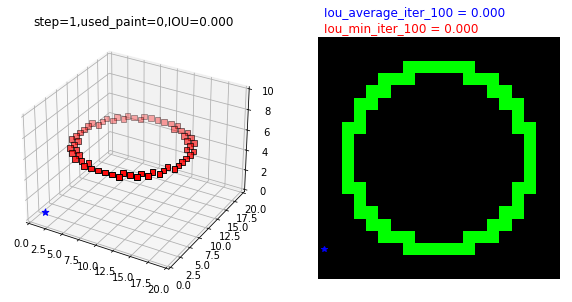

action 2
enter action2_1
check_left
position 3 0
location 0 1
#################


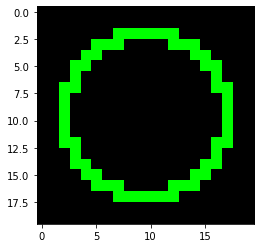

action 1
enter action1_1
check_left
position 3 1
location 1 0
#################


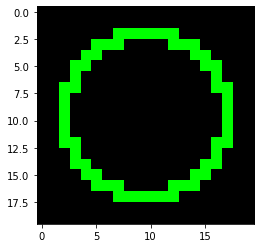

action 2
enter action_none
check_left
position 5 1
location 1 2
#################


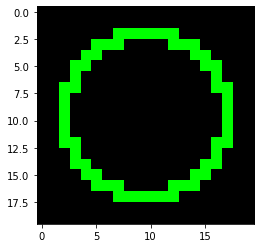

action 1
enter action1_2
position 5 4
location 4 1
#################


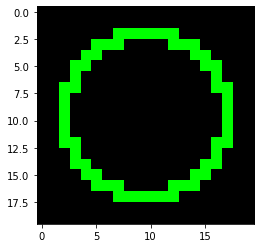

action 1
enter action_none
position 5 7
location 2 4
#################


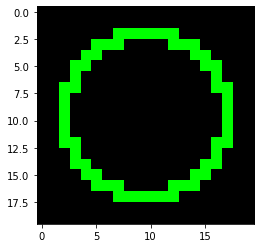

action 2
enter action_none
position 8 7
location 4 3
#################


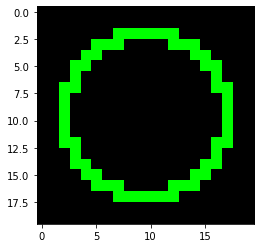

action 5
position 8 7
location 3 4
#################


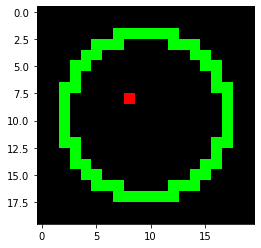

action 5
position 8 7
location 4 3
#################


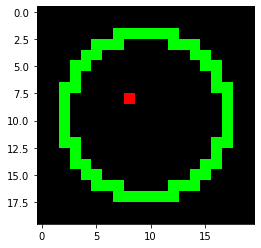

action 5
position 8 7
location 3 4
#################


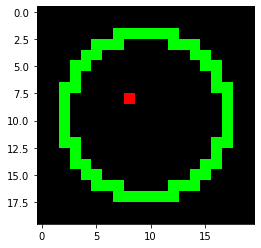

action 5
position 8 7
location 4 3
#################


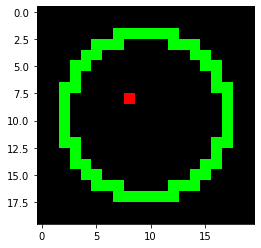

action 5
position 8 7
location 3 4
#################


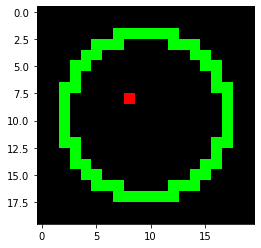

action 5
position 8 7
location 4 3
#################


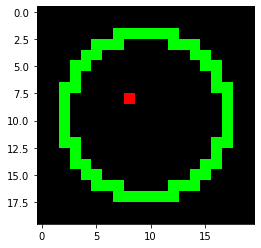

action 6
position 8 7
location 3 4
#################


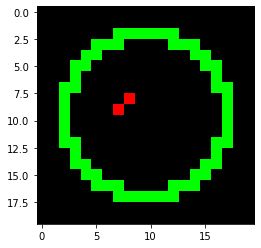

action 6
position 8 7
location 4 3
#################


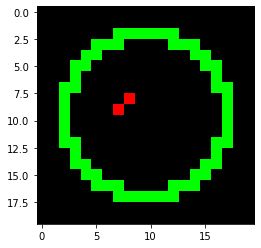

action 6
position 8 7
location 3 4
#################


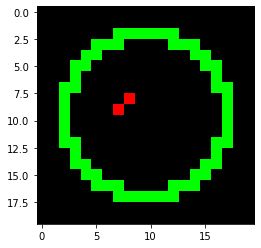

action 6
position 8 7
location 4 3
#################


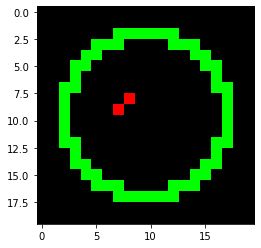

action 6
position 8 7
location 3 4
#################


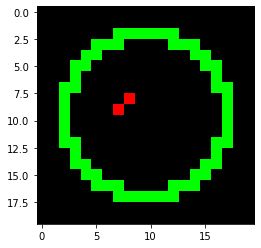

action 6
position 8 7
location 4 3
#################


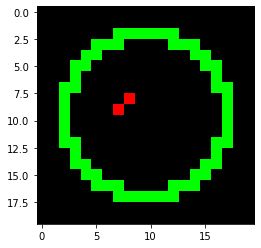

action 3
enter action3_2
position 6 7
location 3 2
#################


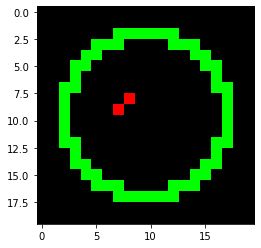

action 1
enter action1_3
position 6 10
location 5 3
#################


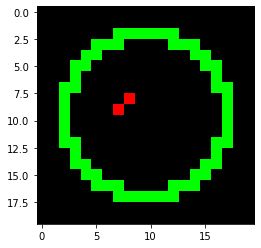

action 2
enter action2_2
position 8 10
location 3 7
#################


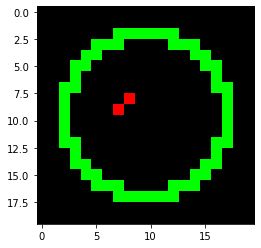

action 2
enter action2_1
position 9 10
location 7 4
#################


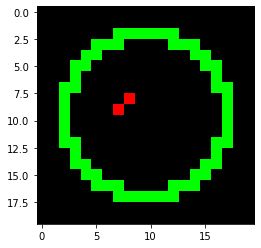

action 4
position 9 10
location 4 7
#################


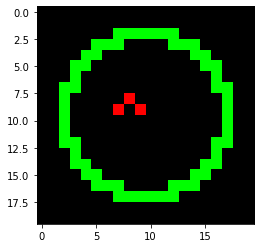

action 7
position 9 10
location 7 4
#################


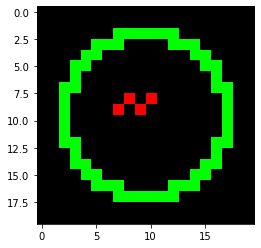

action 4
position 9 10
location 4 7
#################


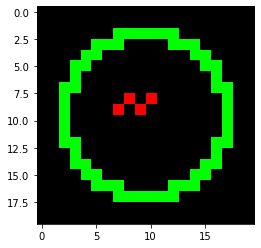

action 7
position 9 10
location 7 4
#################


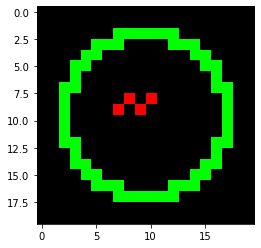

action 4
position 9 10
location 4 7
#################


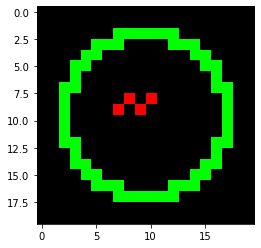

action 7
position 9 10
location 7 4
#################


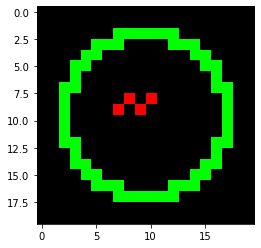

action 4
position 9 10
location 4 7
#################


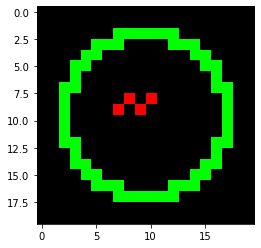

action 7
position 9 10
location 7 4
#################


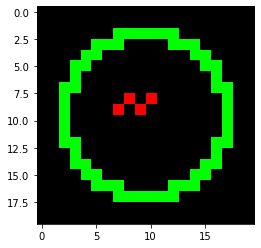

action 4
position 9 10
location 4 7
#################


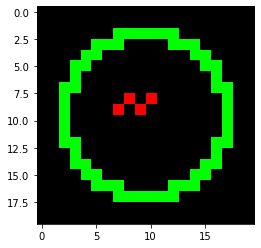

action 7
position 9 10
location 7 4
#################


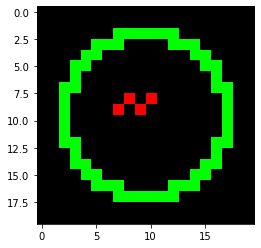

action 4
position 9 10
location 4 7
#################


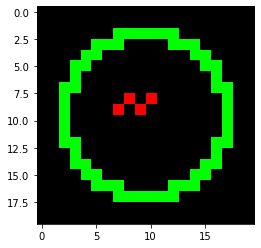

action 7
position 9 10
location 7 4
#################


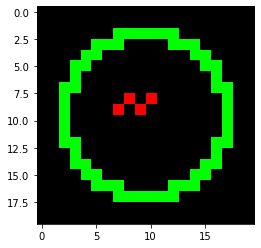

action 2
enter action2_1
position 10 10
location 4 8
#################


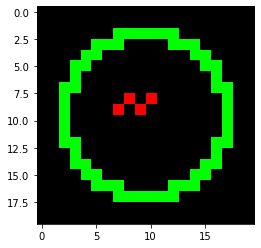

action 3
enter action3_1
position 9 10
location 8 3
#################


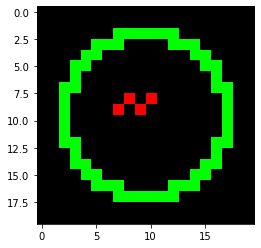

action 2
enter action2_1
position 10 10
location 3 9
#################


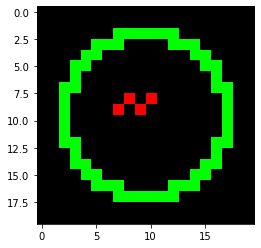

action 7
position 10 10
location 9 3
#################


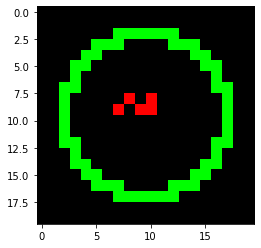

action 4
position 10 10
location 3 9
#################


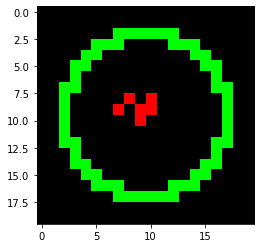

action 7
position 10 10
location 9 3
#################


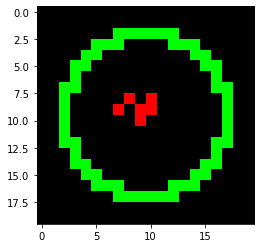

action 4
position 10 10
location 3 9
#################


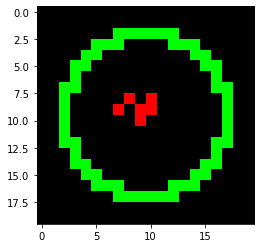

action 7
position 10 10
location 9 3
#################


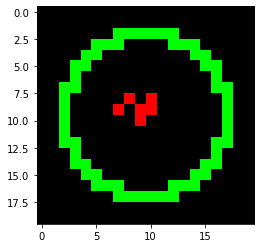

action 4
position 10 10
location 3 9
#################


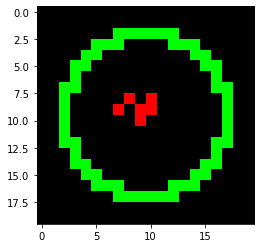

action 7
position 10 10
location 9 3
#################


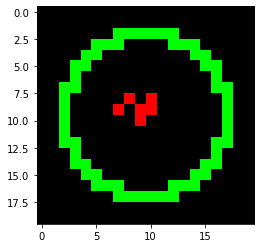

action 4
position 10 10
location 3 9
#################


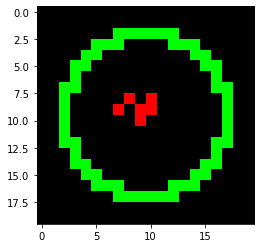

action 7
position 10 10
location 9 3
#################


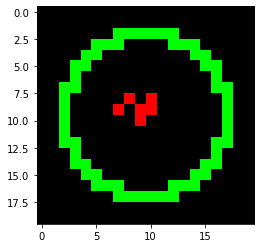

action 4
position 10 10
location 3 9
#################


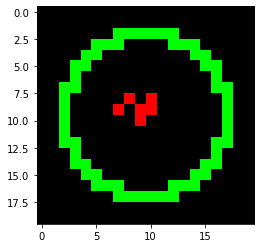

action 7
position 10 10
location 9 3
#################


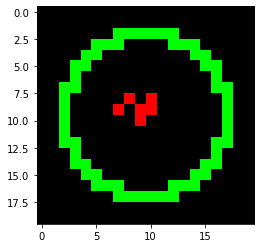

action 4
position 10 10
location 3 9
#################


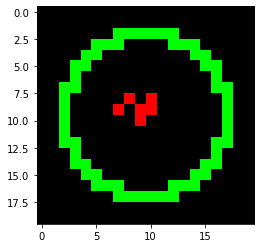

action 1
enter action1_2
position 10 12
location 11 3
#################


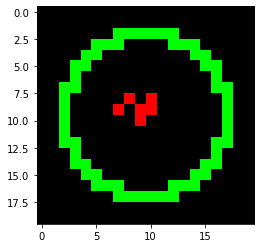

action 4
position 10 12
location 3 11
#################


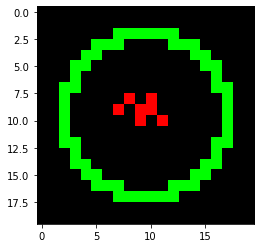

action 7
position 10 12
location 11 3
#################


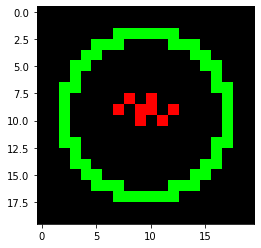

action 4
position 10 12
location 3 11
#################


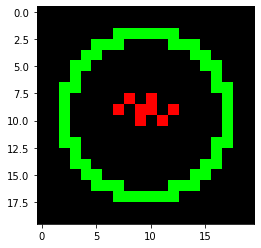

action 7
position 10 12
location 11 3
#################


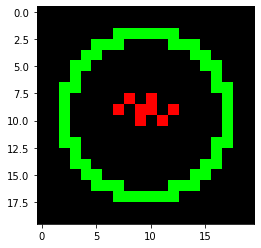

action 4
position 10 12
location 3 11
#################


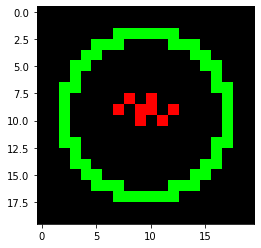

action 7
position 10 12
location 11 3
#################


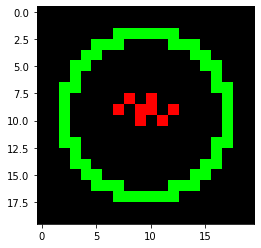

action 4
position 10 12
location 3 11
#################


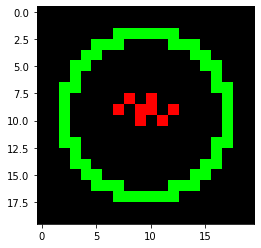

action 7
position 10 12
location 11 3
#################


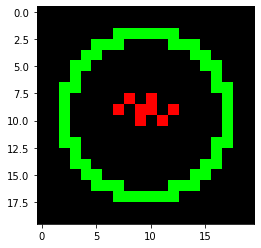

action 4
position 10 12
location 3 11
#################


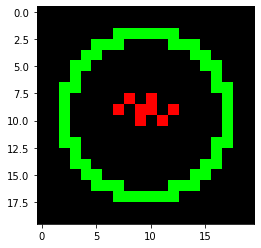

action 7
position 10 12
location 11 3
#################


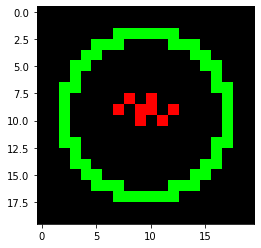

action 4
position 10 12
location 3 11
#################


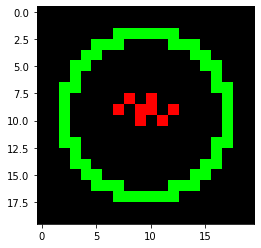

action 7
position 10 12
location 11 3
#################


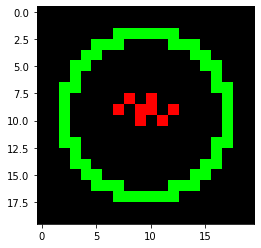

action 6
position 10 12
location 3 11
#################


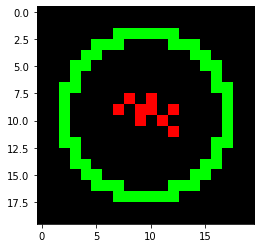

action 5
position 10 12
location 11 3
#################


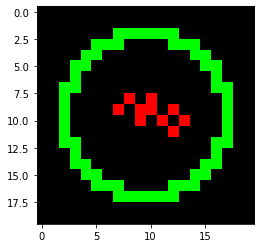

action 6
position 10 12
location 3 11
#################


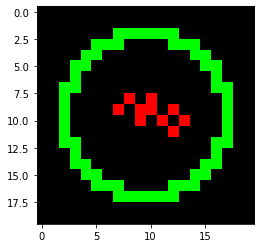

reward: -50.0


In [4]:
env = deep_mobile_printing_3d1r(plan_choose=1)
fig = plt.figure(figsize=[10, 5])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)
total_reward = 0
obs = env.reset()
env.render(ax1, ax2)
print(env.total_brick)
current_position=[0,0]
current_action_prior=[0, 0, 0, 0] 
# print('location', x, y)
# print('position', env.position_memory[-1][1] - 3, env.position_memory[-1][0] - 3)
print('start')
for i in range(1300):
    action,next_action_prior = planing(current_position,obs,current_action_prior)
    print('action', action)
    new_obs, reward, done = env.step(action)
    next_position = localization(action, obs, new_obs, current_position)
    print('position', env.position_memory[-1][0] - 3, env.position_memory[-1][1] - 3)
    print('location', next_position[0], next_position[1])
    print('#################')

    env.render(ax1, ax2)
    plt.pause(0.1)
    total_reward += reward
    obs = new_obs
    current_position=next_position
    current_action_prior=next_action_prior
    if done:
        break
print("reward:", total_reward)
plt.show()
